In [4]:
import pandas as pd
train = pd.read_csv('../input/preprocessed/train_v2.csv')
test = pd.read_csv('../input/preprocessed/test_v2.csv')


In [2]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 400,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}


def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_grad_boost(train, test):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id", "continuous"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        model = GradientBoostingRegressor(**params)
        
        model = model.fit(x_train[features].values, y_train.values)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features].values)
        # Predict the test set
        test_predictions += model.predict(test[features].values) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return test_predictions,model
# Traing and evaluate
predictions_grad_boost,grad_model= train_and_evaluate_grad_boost(train, test)
test['target'] = predictions_grad_boost
test[['row_id', 'target']].to_csv('submission_grad_boost.csv',index = False)


Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Our out of folds RMSPE is 0.3604161152565871


In [3]:
import pickle
filename = 'grad_model.sav'
pickle.dump(grad_model, open(filename, 'wb'))


In [2]:
import pickle
filename = '../input/models/grad_model.sav'
grad_boos = pickle.load(open(filename, 'rb'))


In [17]:
grad_importances = grad_boos.feature_importances_

In [18]:
import numpy as np
indices = np.argsort(grad_importances)

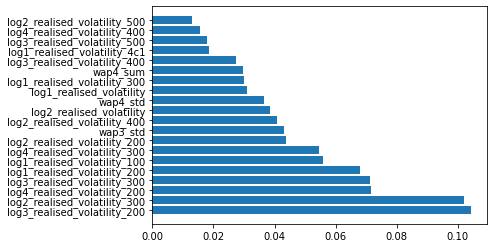

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.barh(range(20), grad_importances[indices[::-1][0:20]])
ax.set_yticks(range(20))
_ = ax.set_yticklabels(np.array(train.columns)[indices[::-1][0:20]])

In [28]:
import pickle
filename1 = '../input/models/adaboost_model.sav'
ada_boos = pickle.load(open(filename1, 'rb'))


In [29]:
ada_importances = ada_boos.feature_importances_


In [30]:
import numpy as np
indices1 = np.argsort(ada_importances)


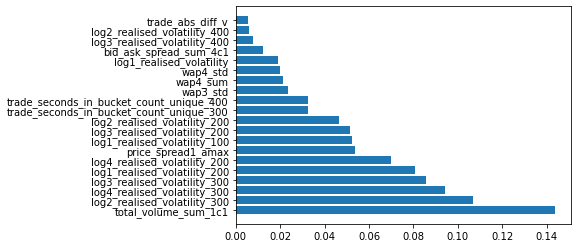

In [31]:
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
ax1.barh(range(20), ada_importances[indices1[::-1][0:20]])
ax1.set_yticks(range(20))
_ = ax1.set_yticklabels(np.array(train.columns)[indices1[::-1][0:20]])